# Evaluation

Evaluating both the performance of the polling averages and my method for combining them.

In [26]:
import os
import json
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

import models as m

In [256]:
# https://stackoverflow.com/questions/65996797
# from importlib import reload
# reload(m)

## Election Results

Calculate Democratic two party voteshare for all senate, house, governor and presidential races.

In [27]:
state_converter = pd.read_csv('data/state_converter.csv')
state_converter.head()

,state,state_abbr,fips
0,Washington,WA,53
1,Delaware,DE,10
2,District of Columbia,DC,11
3,Wisconsin,WI,55
4,West Virginia,WV,54


In [36]:
federal_results = pd.read_csv(
    'data/election_results/results_x2020_11_18_15_02_23.csv',
    dtype={'id': 'object'}
)
federal_results

,race,id,fips_char,fips5,place,fname,lname,party,pab,votes,incumbent,mpc
0,President,0,1,NaN,Alabama,Donald,Trump,REP,R,1434159.0,1.0,1.0
1,President,0,1,NaN,Alabama,Joe,Biden,DEM,D,843473.0,0.0,1.0
2,President,0,1,NaN,Alabama,Jo,Jorgensen,LIB,O,24994.0,0.0,0.0
3,President,0,1,NaN,Alabama,NaN,Write-ins,WRI,O,7274.0,0.0,0.0
4,President,01019,1,1019.0,Cherokee County,Donald,Trump,REP,R,10562.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
52436,President,8,11,NaN,Ward 8,Brock,Pierce,IND,O,162.0,0.0,0.0
52437,President,8,11,NaN,Ward 8,Jo,Jorgensen,LIB,O,131.0,0.0,0.0
52438,Senate,0,11,NaN,District of Columbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52439,House,0,11,NaN,District of Columbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Select pres, senate, etc, then pivot table by party, then use MAX as your aggregator.
# this will give you the top vote getter in each party, not sum.
incl_parties = ['DEM', 'REP']
statewide = federal_results.query('''
    id == "0" and party.isin(@incl_parties)
''')
# # Uses aggfun=max to get the top vote getter by party
statewide = statewide.pivot_table(index=['race','place'],
    values='votes', columns='party', aggfunc='max')
statewide = statewide.reset_index(drop=False)
statewide = statewide.merge(state_converter, left_on='place', right_on='state')
# Arkansas Senate was uncontested, this will give dems a 0% voteshare
statewide[['DEM', 'REP']] = statewide[['DEM', 'REP']].fillna(0)
statewide = statewide.eval('dem_result = DEM/(DEM + REP)')
statewide['id'] = statewide['state_abbr']
statewide = statewide[['race','state_abbr', 'id', 'dem_result']]
statewide['race'] = statewide['race'].replace(
    {'President':'president', 'Senate':'ussenate', 'Governor': 'governor'})
statewide = statewide.rename(columns={'race':'body', 'state_abbr':'state'})

# Loeffler/Warnock matchup
# https://www.politico.com/2020-election/results/georgia/senate-special/
gas_twoparty = 1617035/(1617035+1273214)
ga_special = pd.DataFrame([{'body': 'ussenate', 'state': 'GA', 'id': 'GA-S', 'dem_result':gas_twoparty}])
statewide = pd.concat([statewide, ga_special])
statewide

,body,state,id,dem_result
0,governor,DE,DE,0.606155
1,president,DE,DE,0.596267
2,ussenate,DE,DE,0.610650
3,governor,IN,IN,0.369554
4,president,IN,IN,0.417934
...,...,...,...,...
92,ussenate,VA,VA,0.559752
93,president,WI,WI,0.503173
94,president,WY,WY,0.275196
95,ussenate,WY,WY,0.268642


In [38]:
house = federal_results.query('race == "House" and party.isin(@incl_parties)')
# # # Uses aggfun=max to get the top vote getter by party
house = house.pivot_table(index=['race','fips_char','id'],
    values='votes', columns='party', aggfunc='max')
house = house.reset_index(drop=False)
house = house.merge(state_converter[['state_abbr', 'fips']],
    left_on='fips_char', right_on='fips')

# These results have a convention of using 00 as id for at-large 
# districts, while my projections use 01 as the district. 
# So convert all at larges to 01
house['id'] = house['id'].str[2:]
house['id'] = house['id'].replace({'00':'01'})
house['id'] = house['state_abbr'] + '-' + house['id']

# Fill any NaN values with zero, assuming these are either unopposed,
# same party (CA), or third party. Probably blowouts in these situations.
# # https://www.270towin.com/news/2020/10/30/uncontested-house-races-no-major-party-opposition_1119.html
house[['DEM', 'REP']] = house[['DEM', 'REP']].fillna(0)

house = house.eval('dem_result = DEM/(DEM + REP)')
house = house[['state_abbr', 'id', 'dem_result']]
house['body'] = 'ushouse'
house = house.rename(columns={'state_abbr':'state'})
#Remove null values, not Dem/Rep matchups
#house = house[~house.dem_result.isnull()]
#Check null removals
# ms = house[house.dem_result.isnull()]
# print(len(ms))

stateleg = pd.read_csv('data/election_results/state_legislative_control.csv')
stateleg = stateleg[stateleg.party.isin(["dem", "rep"])]
stateleg = pd.pivot_table(stateleg, index=['state', 'body'],
    columns='party', values='count')
stateleg = stateleg.eval('dem_result = dem/(dem + rep)')
stateleg = stateleg.reset_index(drop=False)
stateleg['id'] = stateleg['state']
stateleg = stateleg.drop(columns=['dem', 'rep'])

results = pd.concat([statewide, house, stateleg])
results

,body,state,id,dem_result
0,governor,DE,DE,0.606155
1,president,DE,DE,0.596267
2,ussenate,DE,DE,0.610650
3,governor,IN,IN,0.369554
4,president,IN,IN,0.417934
...,...,...,...,...
95,statesenate,WI,WI,0.375000
96,statehouse,WV,WV,0.230000
97,statesenate,WV,WV,0.323529
98,statehouse,WY,WY,0.120690


In [39]:
projections = pd.read_csv('data/output/projected_results.csv')
projections.rename(columns={'value':'projection'}, inplace=True)
projections

,state,body,id,measure,projection,low,high
0,WY,president,WY,dem two party voteshare,0.307423,0.269915,0.346847
1,WV,president,WV,dem two party voteshare,0.354434,0.315643,0.394822
2,OK,president,OK,dem two party voteshare,0.363814,0.322586,0.406572
3,ID,president,ID,dem two party voteshare,0.369899,0.327096,0.414542
4,ND,president,ND,dem two party voteshare,0.374696,0.333556,0.417334
...,...,...,...,...,...,...,...
613,NY,statesenate,NY,dem two party seat share,0.669897,0.555556,0.777778
614,DE,statesenate,DE,dem two party seat share,0.670205,0.571429,0.761905
615,OR,statesenate,OR,dem two party seat share,0.670340,0.566667,0.800000
616,NM,statesenate,NM,dem two party seat share,0.670412,0.547619,0.785714


# Polling/Rating Error

In [194]:
projected = projections.merge(results, on=['state', 'body', 'id'])
# projected = projected.eval('pe = 100*(dem_result - projection)/dem_result') # Percent error
# projected['ape'] = projected['pe'].abs() # Absolute percent error
# projected.sort_values(by='ape', ascending=False)
projected = projected.eval('error = dem_result - projection') # Percent error
projected['absolute_error'] = projected['error'].abs() # Absolute percent error
projected.sort_values(by='error', ascending=False)

,state,body,id,measure,projection,low,high,dem_result,error,absolute_error
389,NY,ushouse,NY-05,dem two party voteshare,0.669213,0.556404,0.783320,1.0,0.330787,0.330787
350,MA,ushouse,MA-01,dem two party voteshare,0.669614,0.553914,0.783874,1.0,0.330386,0.330386
283,CA,ushouse,CA-38,dem two party voteshare,0.669724,0.555303,0.782985,1.0,0.330276,0.330276
425,RI,ushouse,RI-01,dem two party voteshare,0.669770,0.558453,0.784063,1.0,0.330230,0.330230
330,IL,ushouse,IL-08,dem two party voteshare,0.669784,0.554106,0.786093,1.0,0.330216,0.330216
...,...,...,...,...,...,...,...,...,...,...
236,VA,ushouse,VA-09,dem two party voteshare,0.330509,0.216194,0.445334,0.0,-0.330509,0.330509
95,AR,ushouse,AR-01,dem two party voteshare,0.330956,0.216703,0.447008,0.0,-0.330956,0.330956
53,AR,ussenate,AR,dem two party voteshare,0.399902,0.269721,0.551632,0.0,-0.399902,0.399902
116,FL,ushouse,FL-25,dem two party voteshare,0.330888,0.217865,0.445251,NaN,NaN,NaN


In [195]:
# Missing values:
# Update: no missing values now!!!
# All the missing values are from ushouse, and georgia special. How is that one labeled?
# Georgia special is also missing from original data, not just a join issue
# And House races are also missing. Maybe find a different data source for House?
# Are these missing because they're not a traditional D/R matchup?
# Yes, 27 out of the 33 missing House races are not D/R matchups
# Are the others just missing? No, they're at-large districts, coded as 00 in results but 01 in projections?
missing = projections.merge(results, on=['state', 'body', 'id'], how='left', indicator=True)
missing = missing.query('_merge == "left_only"')
print(len(missing))
missing

0


,state,body,id,measure,projection,low,high,dem_result,_merge


## Error, All Elections

In [241]:
out_str = 'data/output/evaluation/{}'

all_error = projected.groupby(by='body').agg(
    mean_error=('error', 'mean'),
    mean_absolute_error = ('absolute_error','mean')
).sort_values(by='mean_absolute_error', ascending=False)

m.output_table(all_error, out_str.format('all_error.html'))
all_error

,mean_error,mean_absolute_error
body,,
statesenate,-0.030646,0.093386
statehouse,-0.041457,0.083804
ushouse,0.001982,0.081726
ussenate,-0.048993,0.052367
governor,-0.042144,0.049448
president,-0.022684,0.023236


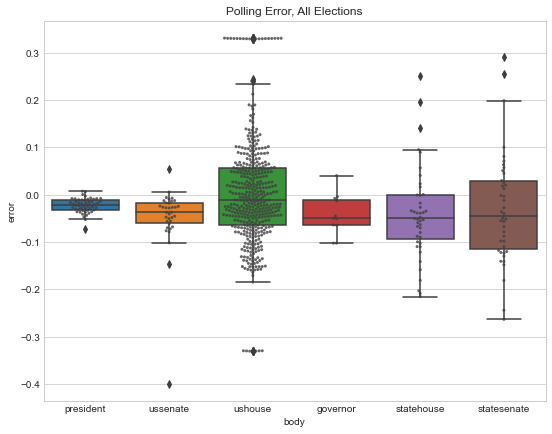

In [199]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.set_title('Polling Error, All Elections')
sns.boxplot(data=projected, x='body', y='error', ax=ax)
sns.swarmplot(data=projected, x='body', y='error', color=".25", size=3, alpha=0.8, ax=ax)
plt.savefig(out_str.format('all_error.png', bbox_inches='tight'))
plt.show()

## Error, Close Elections

In [253]:
# TODO: Do you want error based on dem_result 0.4-0.6, or your projection 0.4-0.6?
# Or both? Error inside out, or outside in will be ignored in either case.
close_error = projected.query('0.4 < dem_result < 0.6').groupby(by='body').agg(
        mean_error=('error', 'mean'),
        mean_absolute_error = ('absolute_error','mean')
    ).sort_values(by='mean_absolute_error', ascending=False) #.style.background_gradient()

m.output_table(close_error, out_str.format('close_error.html'))
close_error

,mean_error,mean_absolute_error
body,,
statehouse,-0.066242,0.082076
ushouse,-0.048813,0.080224
statesenate,-0.069733,0.069733
governor,-0.057344,0.057344
ussenate,-0.027483,0.033106
president,-0.020784,0.021244


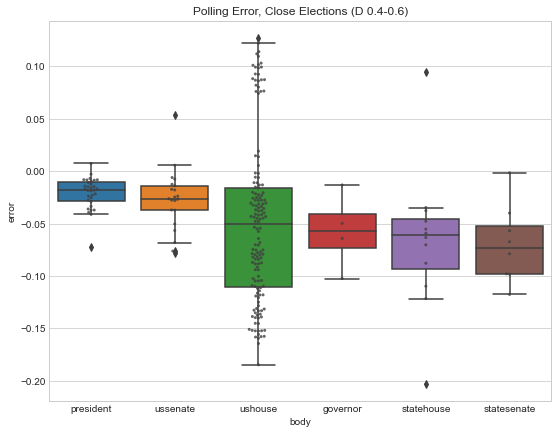

In [254]:
low = 0.4
high = 0.6

fig, ax = plt.subplots(figsize=(9, 7))
ax.set_title('Polling Error, Close Elections (D 0.4-0.6)')
sns.boxplot(data=projected.query('@low < dem_result < @high'), x='body', y='error', ax=ax)
sns.swarmplot(data=projected.query('@low < dem_result < @high'),
    x='body', y='error', color=".25", size=3, alpha=0.8, ax=ax)
plt.savefig(out_str.format('close_error.png', bbox_inches='tight'))
plt.show()

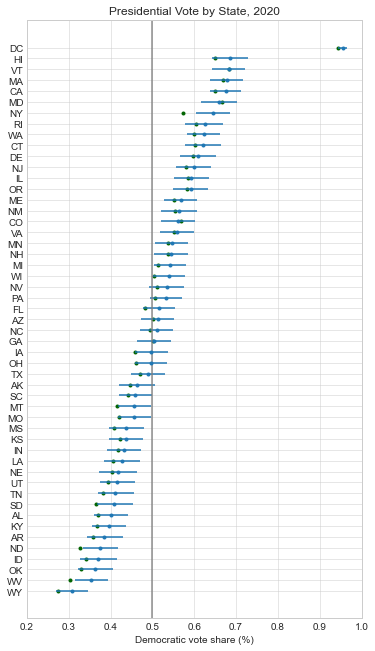

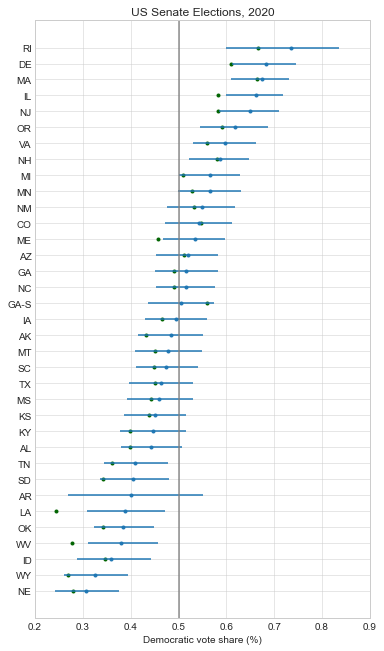

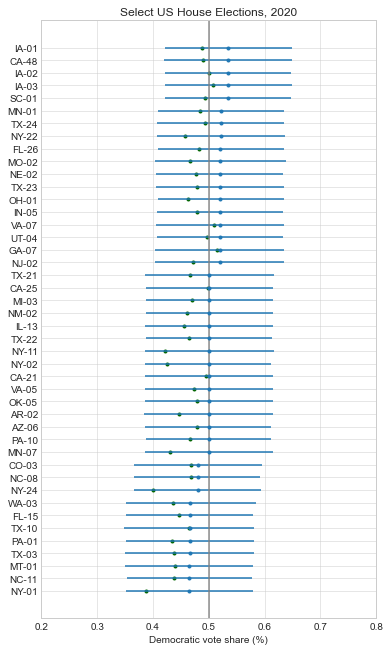

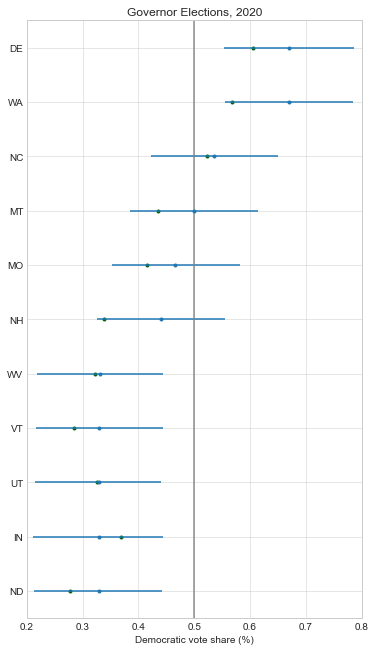

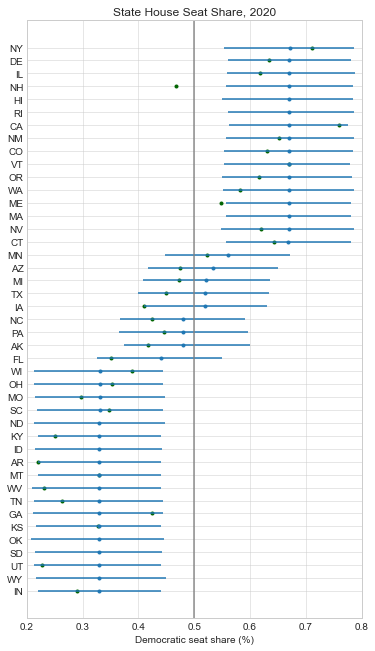

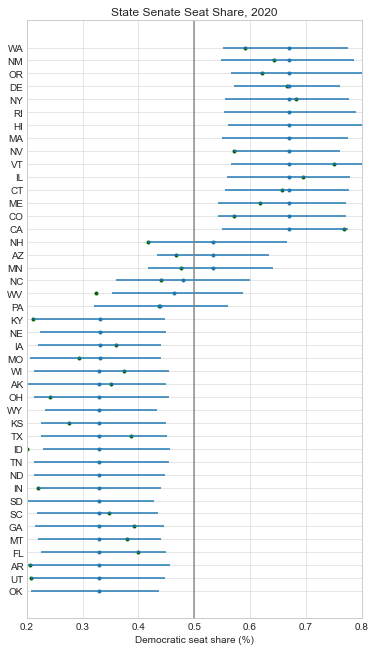

In [46]:
def reproduce_seatplots(df):
    temp = df.copy()
    # Matplotlib defines error relative to point, not in absolute terms.
    temp = temp.eval('upper = high - projection')
    temp = temp.eval('lower = projection - low')
    
    votestr = 'Democratic vote share (%)'
    seatstr = 'Democratic seat share (%)'
    outstr = 'data/output/evaluation/{}'
    
    plot_specs = {
        'president': {'x_label':votestr, 'title':'Presidential Vote by State, 2020', 'out':outstr.format('presidentialstates.png'), 'xlim':[0.2,1.0]},
        'ussenate': {'x_label':votestr, 'title':'US Senate Elections, 2020', 'out':outstr.format('senateseats.png'), 'xlim':[0.2,0.9]},
        'ushouse': {'x_label':votestr, 'title':'Select US House Elections, 2020', 'out':outstr.format('houseseats.png'), 'xlim':[0.2, 0.8]},
        'governor': {'x_label':votestr, 'title':'Governor Elections, 2020', 'out':outstr.format('govseats.png')},
        'statehouse': {'x_label':seatstr, 'title':'State House Seat Share, 2020', 'out':outstr.format('statehouseseats.png')},
        'statesenate': {'x_label':seatstr, 'title':'State Senate Seat Share, 2020', 'out':outstr.format('statesenateseats.png')}
    }

    for body in plot_specs.keys():
        spec = plot_specs[body]
        plot_df = temp.query('body == @body')
        plot_df = plot_df.sort_values(by='projection', ascending=True).reset_index()
        # Filter house visualization to show key races
        if body == 'ushouse':
            plot_df = plot_df[
                (plot_df['projection'] > 0.45) &
                (plot_df['projection'] < 0.55)
            ]
        m.seatplot(plot_df, x='projection', y='id', outcome='dem_result', **spec)
        
reproduce_seatplots(projected)

# Model Evaluation
What would the model prioritize if we had perfect polling? I run all the models with probability distributions centered at the actual outcome.

In [47]:
#Power sharing
state_metadata = pd.read_csv('data/state_metadata.csv')
stateleg_metadata = pd.read_csv('data/state_legislature_metadata.csv')
power = m.calculate_seat_power(state_metadata, stateleg_metadata)
power['state_power'].head()

,fips,state_abbr,state_name,governor_power,state_senate_power,state_house_power
0,1,AL,Alabama,0.373499,0.186750,0.186750
1,2,AK,Alaska,0.056350,0.028175,0.028175
2,4,AZ,Arizona,0.548010,0.274005,0.274005
3,5,AR,Arkansas,0.230297,0.115148,0.115148
4,6,CA,California,3.022691,1.511346,1.511346


In [48]:
model_data = results.copy()
# Rename columns to match model columns
model_data = model_data.rename(columns={'dem_result':'dem', 'id':'district'})
model_data

,body,state,district,dem
0,governor,DE,DE,0.606155
1,president,DE,DE,0.596267
2,ussenate,DE,DE,0.610650
3,governor,IN,IN,0.369554
4,president,IN,IN,0.417934
...,...,...,...,...
95,statesenate,WI,WI,0.375000
96,statehouse,WV,WV,0.230000
97,statesenate,WV,WV,0.323529
98,statehouse,WY,WY,0.120690


## President

In [49]:
# 2016/2020 Presidential electoral votes by state for model input
electoral_votes = state_metadata[['state_abbr', 'electoral_votes_2016']]
electoral_votes = electoral_votes.rename(
    columns={'state_abbr':'state', 'electoral_votes_2016': 'EV'})
electoral_votes = electoral_votes.set_index('state')

# Actual two party democratic outcome
pres_data = model_data.query('body == "president"')
pres_data = pres_data[['state', 'dem']].set_index('state')
pres_data.head()

,dem
state,
DE,0.596267
IN,0.417934
MO,0.420635
MT,0.416034
NH,0.537489


In [50]:
presidential_results = m.simulate_president(n=10000, state_uncertainty_sd=0.05, 
    national_uncertainty_sd=0.03, state_data=pres_data,
    electoral_votes=electoral_votes)

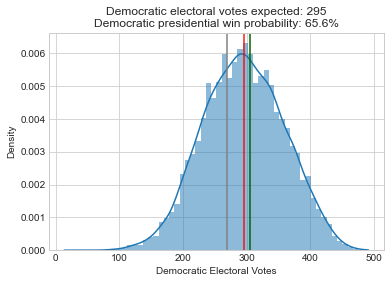

In [51]:
pres_sims = np.array(presidential_results['dem_ev_sim'])
ec_ev_exp = np.mean(pres_sims)
ec_dem_win_prob = np.round(((pres_sims >= 269).sum()/len(pres_sims))*100, decimals=1)
ec_prob_close = m.normed_prob(pres_sims, bounds=[0, 538])
ec_title = 'Democratic electoral votes expected: {0}\nDemocratic presidential win probability: {1}%'\
    .format(round(ec_ev_exp), ec_dem_win_prob)
m.plot_histogram(pres_sims, ec_ev_exp, 269, ec_title,
    out='data/output/evaluation/model_presidentialhist.png',
    x_label='Democratic Electoral Votes', outcome=306)
plt.show()

In [56]:
pres_summary = presidential_results['summary'].sort_values(by='pr_tip', ascending=False)
pres_summary.head(15)

,state,mean,q_025,q_975,pr_tip
22,MI,0.514438,0.401564,0.626595,0.084621
38,PA,0.505996,0.389474,0.619294,0.069846
10,GA,0.502020,0.385786,0.616475,0.067831
48,WI,0.503330,0.388471,0.615858,0.063130
3,AZ,0.502077,0.389452,0.614547,0.063130
9,FL,0.483459,0.369372,0.596789,0.059772
27,NC,0.493617,0.378878,0.606787,0.055071
23,MN,0.536492,0.424078,0.651276,0.053727
45,VA,0.550875,0.438373,0.663738,0.048355
35,OH,0.459076,0.346157,0.572380,0.038952


In [99]:
# One issue is that this model doesn't differentiate between
# states as much. The really wide confidence intervals give
# many states a fairly high pr_tip, while narrower bounds allow
# you to focus in on certain states. Maybe that's for the better though?
presidential_power = pres_summary.copy()
presidential_power['pr_close'] = ec_prob_close
presidential_power['potential_power'] = power['presidential_power']
presidential_power = presidential_power.eval('realized_power = potential_power*pr_close*pr_tip')
presidential_power[['office', 'district']] = ('president', None)
presidential_power.rename(columns={'mean':'mean_vote'}, inplace=True)
presidential_power

,state,mean_vote,q_025,q_975,pr_tip,pr_close,potential_power,realized_power,office,district
22,MI,0.514438,0.401564,0.626595,0.084621,0.148253,25.0,0.313632,president,None
38,PA,0.505996,0.389474,0.619294,0.069846,0.148253,25.0,0.258871,president,None
10,GA,0.502020,0.385786,0.616475,0.067831,0.148253,25.0,0.251403,president,None
48,WI,0.503330,0.388471,0.615858,0.063130,0.148253,25.0,0.233979,president,None
3,AZ,0.502077,0.389452,0.614547,0.063130,0.148253,25.0,0.233979,president,None
9,FL,0.483459,0.369372,0.596789,0.059772,0.148253,25.0,0.221533,president,None
27,NC,0.493617,0.378878,0.606787,0.055071,0.148253,25.0,0.204109,president,None
23,MN,0.536492,0.424078,0.651276,0.053727,0.148253,25.0,0.199131,president,None
45,VA,0.550875,0.438373,0.663738,0.048355,0.148253,25.0,0.179218,president,None
35,OH,0.459076,0.346157,0.572380,0.038952,0.148253,25.0,0.144370,president,None


## US Senate

My new model

In [58]:
# Actual two party democratic outcome
senate_data = model_data.query('body == "ussenate"')

senate_results = m.simulate_senate(n=10000, state_uncertainty_sd=0.05, 
    national_uncertainty_sd=0.03, senate_data=senate_data, safe_dem_seats=35)

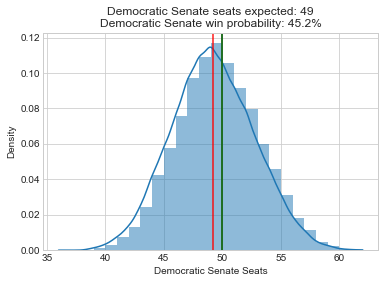

In [60]:
senate_sims = np.array(senate_results['dem_seats'])
senate_exp = np.mean(senate_sims)
senate_bins = np.max(senate_sims) - np.min(senate_sims)
senate_dem_win_prob = np.round(((senate_sims >= 50).sum()/len(senate_sims))*100, decimals=1)
senate_prob_close = m.normed_prob(senate_sims, bounds=[0, 100])
senate_title = 'Democratic Senate seats expected: {0}\nDemocratic Senate win probability: {1}%'\
    .format(round(senate_exp), senate_dem_win_prob) #round(senate_exp)
m.plot_histogram(senate_sims, senate_exp, 50, senate_title,
    out='data/output/evaluation/model_senatehist.png',
    x_label='Democratic Senate Seats', outcome=50, bins=senate_bins)
plt.show()

In [84]:
senate_power = senate_results['summary'].copy()
senate_power['pr_close'] = senate_prob_close
senate_power['potential_power'] = power['senate_power']
senate_power = senate_power.eval('realized_power = potential_power*pr_close*pr_tip')
senate_power['office'] = 'ussenate'
senate_power.sort_values(by='realized_power', ascending=False)

,state,district,mean_vote,q_025,q_975,pr_tip,pr_close,potential_power,realized_power,office
10,GA,GA,0.491173,0.379513,0.605110,0.083913,0.496616,12.5,0.520909,ussenate
3,NC,NC,0.490676,0.377933,0.602754,0.073374,0.496616,12.5,0.455487,ussenate
19,MI,MI,0.508599,0.396543,0.622656,0.072977,0.496616,12.5,0.453018,ussenate
13,IA,IA,0.465246,0.353963,0.577453,0.067807,0.496616,12.5,0.420924,ussenate
7,AZ,AZ,0.512219,0.398524,0.626642,0.065619,0.496616,12.5,0.407346,ussenate
17,ME,ME,0.456605,0.341363,0.571747,0.059057,0.496616,12.5,0.366611,ussenate
20,MN,MN,0.528313,0.416894,0.642910,0.058859,0.496616,12.5,0.365377,ussenate
31,TX,TX,0.450298,0.336098,0.567305,0.056075,0.496616,12.5,0.348095,ussenate
24,NM,NM,0.531747,0.419222,0.647992,0.055081,0.496616,12.5,0.341923,ussenate
1,MT,MT,0.449485,0.337463,0.561522,0.052694,0.496616,12.5,0.327111,ussenate


## US House

In [64]:
# US House model
house_data = model_data.query('body == "ushouse"')
house_results = m.simulate_house(n=10000, state_uncertainty_sd=0.05, 
    national_uncertainty_sd=0.03, house_data=house_data)

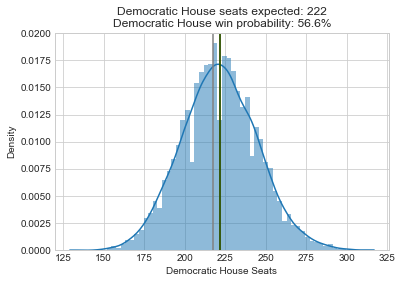

In [67]:
house_summary = pd.DataFrame.from_dict(house_results['summary'])

house_sims = np.array(house_results['dem_seats'])
house_mean_seats = house_sims.mean()
house_win_prob = (house_sims >= 218).sum()/len(house_sims)
house_prob_close = m.normed_prob(house_sims, bounds=[0, 435])
house_title = 'Democratic House seats expected: {0}\nDemocratic House win probability: {1}%'\
    .format(round(house_mean_seats), np.round(house_win_prob*100, 1))
m.plot_histogram(house_sims, house_mean_seats, 217.5, house_title, outcome=222,
    x_label='Democratic House Seats', out='data/output/evaluation/model_househist.png')

In [83]:
house_power = m.get_house_power(house_results, power['house_power'],
    house_prob_close, house_data)
house_power.sort_values(by='realized_power', ascending=False)
house_power = house_power.merge(house_summary, on=['state', 'district'])
house_power

,state,office,district,potential_power,pr_close,pr_tip,realized_power,mean_vote,q_025,q_975
0,IA,ushouse,IA-02,12.5,0.353275,0.012868,0.056825,0.499664,0.387341,0.616165
1,UT,ushouse,UT-04,12.5,0.353275,0.012558,0.055456,0.497422,0.385609,0.611127
2,FL,ushouse,FL-27,12.5,0.353275,0.012403,0.054771,0.486865,0.374100,0.601164
3,PA,ushouse,PA-08,12.5,0.353275,0.011783,0.052033,0.518773,0.406213,0.633266
4,NY,ushouse,NY-18,12.5,0.353275,0.011783,0.052033,0.518325,0.403107,0.634822
...,...,...,...,...,...,...,...,...,...,...
430,MA,ushouse,MA-07,12.5,0.353275,0.000000,0.000000,0.976966,0.887749,1.000000
431,MA,ushouse,MA-08,12.5,0.353275,0.000000,0.000000,0.976928,0.884034,1.000000
432,MI,ushouse,MI-04,12.5,0.353275,0.000000,0.000000,0.332131,0.216290,0.446401
433,MI,ushouse,MI-10,12.5,0.353275,0.000000,0.000000,0.336826,0.222316,0.450616


## Governors

In [ ]:
gov_data = model_data.query('body == "governor"')
gov_results = m.simulate_governors(n=10000, state_uncertainty_sd=0.05,
    national_uncertainty_sd=0.03, govs=gov_data)

In [74]:
gov_summary = pd.DataFrame.from_dict(gov_results['summary'])
gov_power = m.get_governor_power(gov_summary, power['state_power'])
# Just merge all results together
gov_power = gov_power.merge(gov_summary[['state', 'mean_vote', 'q_025', 'q_975']], on='state')
gov_power

,state,office,district,potential_power,pr_close,pr_tip,realized_power,mean_vote,q_025,q_975
0,NC,governor,None,0.793448,0.309757,1,0.245776,0.521264,0.407360,0.637800
1,WA,governor,None,0.575821,0.179807,1,0.103537,0.567185,0.453046,0.680367
2,MO,governor,None,0.468143,0.120526,1,0.056424,0.414379,0.297035,0.530699
3,IN,governor,None,0.511350,0.033147,1,0.016949,0.370001,0.255027,0.485463
4,MT,governor,None,0.081174,0.185617,1,0.015067,0.434980,0.321346,0.549092
5,DE,governor,None,0.073905,0.072753,1,0.005377,0.605296,0.490116,0.718965
6,UT,governor,None,0.241551,0.005006,1,0.001209,0.324495,0.208272,0.437779
7,NH,governor,None,0.103652,0.010529,1,0.001091,0.338765,0.225636,0.454308
8,WV,governor,None,0.137990,0.004773,1,0.000659,0.321843,0.206363,0.438977
9,VT,governor,None,0.047858,0.000500,1,0.000024,0.284894,0.169750,0.398803


## State Houses

In [146]:
# State Houses
sh = model_data.query('body == "statehouse"')
sh = sh.merge(stateleg_metadata[['state_abbr', 'house_num']],
    left_on = 'state', right_on = 'state_abbr'
)
# I model expected number of seats, so % seat share converted to seats
sh['dem'] = sh['house_num']*sh['dem']
sh = sh.query('state_abbr != "NE"') # Remove Nebraska, it's "nonpartisan"

statehouse_results = m.simulate_statehouses(n=10000, state_uncertainty_sd=0.05,
    national_uncertainty_sd=0.03, house_data=sh)

In [88]:
statehouse_summary = pd.DataFrame(statehouse_results['summary'])
statehouse_summary.sort_values(by='pr_close', ascending=False, inplace=True)
statehouse_summary.reset_index(drop=True, inplace=True)
statehouse_summary = statehouse_summary.merge(
    stateleg_metadata[['state_abbr', 'house_num']],
    left_on='state', right_on='state_abbr'
)
statehouse_summary[['mean_seats', 'q_025', 'q_975']] = statehouse_summary[['mean_seats', 'q_025', 'q_975']] \
    .div(statehouse_summary['house_num'], axis=0)
# Just title two party seat share mean_vote so I can concat with other data
statehouse_summary.rename(columns={'mean_seats':'mean_vote'}, inplace=True)

statehouse_power = m.get_statehouse_power(statehouse_summary, power['state_power'])
# Just merge all results together
statehouse_power = statehouse_power.merge(
    statehouse_summary[['state', 'mean_vote', 'q_025', 'q_975']], on='state')
statehouse_power.head(10)

,state,office,district,potential_power,pr_close,pr_tip,realized_power,mean_vote,q_025,q_975
0,TX,statehouse,None,1.096604,2.288027e-01,1,2.509059e-01,0.450321,0.340000,0.566667
1,MI,statehouse,None,0.381911,2.998912e-01,1,1.145318e-01,0.471661,0.354545,0.581818
2,PA,statehouse,None,0.489316,2.187837e-01,1,1.070544e-01,0.445417,0.330049,0.561576
3,AZ,statehouse,None,0.274005,2.941990e-01,1,8.061206e-02,0.475070,0.366667,0.583333
4,VA,statehouse,None,0.325433,2.343413e-01,1,7.626237e-02,0.549908,0.440000,0.660000
5,MN,statehouse,None,0.214385,3.086861e-01,1,6.617762e-02,0.522238,0.410448,0.634328
6,NC,statehouse,None,0.396724,1.576702e-01,1,6.255158e-02,0.425391,0.308333,0.541667
7,GA,statehouse,None,0.401915,1.534053e-01,1,6.165587e-02,0.425174,0.311111,0.538889
8,WA,statehouse,None,0.287910,1.343651e-01,1,3.868511e-02,0.582224,0.469388,0.693878
9,IL,statehouse,None,0.486795,4.755782e-02,1,2.315091e-02,0.618881,0.508475,0.728814


## State Senates

In [91]:
# State Senates
ss = model_data.query('body == "statesenate"')
ss = ss.merge(stateleg_metadata[['state_abbr', 'senate_num']],
    left_on = 'state', right_on = 'state_abbr'
)
# I model expected number of seats, so % seat share converted to seats
ss['dem'] = ss['senate_num']*ss['dem']
ss = ss.query('state_abbr != "NE"') # Remove Nebraska, it's "nonpartisan"

statesenate_results = m.simulate_statesenates(n=10000, state_uncertainty_sd=0.05,
    national_uncertainty_sd=0.03, senate_data=ss)

In [97]:
statesenate_summary = pd.DataFrame(statesenate_results['summary'])
statesenate_summary = statesenate_summary.merge(
    stateleg_metadata[['state_abbr', 'senate_num']],
    left_on='state', right_on='state_abbr'
)
statesenate_summary[['mean_seats', 'q_025', 'q_975']] = statesenate_summary[['mean_seats', 'q_025', 'q_975']] \
    .div(statesenate_summary['senate_num'], axis=0)
# Just title two party seat share mean_vote so I can concat with other data
statesenate_summary.rename(columns={'mean_seats':'mean_vote'}, inplace=True)

statesenate_power = m.get_statesenate_power(statesenate_summary, power['state_power'])
# Just merge all results together
statesenate_power = statesenate_power.merge(
    statesenate_summary[['state', 'mean_vote', 'q_025', 'q_975']], on='state')
statesenate_power.sort_values(by='realized_power', ascending=False).head(10)

,state,office,district,potential_power,pr_close,pr_tip,realized_power,mean_vote,q_025,q_975
0,PA,statesenate,None,0.489316,0.193675,1,0.094768,0.436292,0.320000,0.540000
1,VA,statesenate,None,0.325433,0.270128,1,0.087908,0.538297,0.425000,0.650000
2,NC,statesenate,None,0.396724,0.203557,1,0.080756,0.439454,0.320000,0.560000
3,TX,statesenate,None,1.096604,0.064144,1,0.070341,0.386719,0.258065,0.516129
4,AZ,statesenate,None,0.274005,0.253123,1,0.069357,0.466213,0.366667,0.566667
5,FL,statesenate,None,0.813778,0.084030,1,0.068382,0.399695,0.275000,0.525000
6,MN,statesenate,None,0.214385,0.302234,1,0.064794,0.476434,0.358209,0.597015
7,MI,statesenate,None,0.381911,0.137513,1,0.052518,0.420205,0.315789,0.526316
8,CO,statesenate,None,0.217609,0.172554,1,0.037549,0.570900,0.457143,0.685714
9,WA,statesenate,None,0.287910,0.104460,1,0.030075,0.591757,0.469388,0.714286


## Combined Results

In [135]:
model_results = pd.concat([presidential_power, senate_power,
    house_power, gov_power, statesenate_power, statehouse_power])
order = ['state', 'office', 'district', 'mean_vote', 'q_025', 'q_975',
    'potential_power', 'pr_close', 'pr_tip', 'realized_power']
model_results = model_results[order].sort_values(by='realized_power', ascending=False)
model_results.head(50)

,state,office,district,mean_vote,q_025,q_975,potential_power,pr_close,pr_tip,realized_power
10,GA,ussenate,GA,0.491173,0.379513,0.605110,12.500000,0.496616,0.083913,0.520909
3,NC,ussenate,NC,0.490676,0.377933,0.602754,12.500000,0.496616,0.073374,0.455487
19,MI,ussenate,MI,0.508599,0.396543,0.622656,12.500000,0.496616,0.072977,0.453018
13,IA,ussenate,IA,0.465246,0.353963,0.577453,12.500000,0.496616,0.067807,0.420924
7,AZ,ussenate,AZ,0.512219,0.398524,0.626642,12.500000,0.496616,0.065619,0.407346
17,ME,ussenate,ME,0.456605,0.341363,0.571747,12.500000,0.496616,0.059057,0.366611
20,MN,ussenate,MN,0.528313,0.416894,0.642910,12.500000,0.496616,0.058859,0.365377
31,TX,ussenate,TX,0.450298,0.336098,0.567305,12.500000,0.496616,0.056075,0.348095
24,NM,ussenate,NM,0.531747,0.419222,0.647992,12.500000,0.496616,0.055081,0.341923
1,MT,ussenate,MT,0.449485,0.337463,0.561522,12.500000,0.496616,0.052694,0.327111


In [147]:
model_results.to_csv('data/output/evaluation/combined_results.csv', index=False)

## Summary by Office

In [243]:
office_summary = model_results.groupby(by='office') \
    .agg(realized_power_model=('realized_power','sum')) \
    .sort_values(by='realized_power_model', ascending=False)

previous_results = pd.DataFrame(
    {'office':['ussenate', 'ushouse', 'president', 'statehouse', 'statesenate', 'governor'],
    'realized_power_2020':[6.14, 1.46, 1.23, 1.105, 0.445, 0.411]})
previous_results.set_index('office', inplace=True)

office_summary = previous_results.merge(office_summary,
    left_index=True, right_index=True)
office_summary = office_summary.eval('change = realized_power_model - realized_power_2020')
m.output_table(office_summary, out_str.format('office_summary.html'))
office_summary

,realized_power_2020,realized_power_model,change
office,,,
ussenate,6.140,6.207701,0.067701
ushouse,1.460,4.415933,2.955933
president,1.230,3.706329,2.476329
statehouse,1.105,1.004073,-0.100927
statesenate,0.445,0.762747,0.317747
governor,0.411,0.446129,0.035129


Interpretation: Senate is just as important as in initial model, but relative importance of house and presidency have increased dramatically (~3x). So I guess this could be interpreted as saying that the Senate races are still the most important, but you need to increase the total resources put into this election, and target that increase to the house and presidency. This highlights a problem with my model though, it doesn't consider the marginal use of money, or take into account the cumulative amount. It's just a statement of what the overall priorities should be, not where money should currently be allocated. But you could calculate % of realized power for each seat, and compare it to % of funds allocated to find places that are underresourced relative to their power.  

## Summary by State

In [144]:
matrix = model_results.groupby(by=['state', 'office']).agg({'realized_power': 'sum'})
matrix = matrix.pivot_table(index='state', columns='office', values='realized_power')
matrix['sum'] = matrix.sum(axis=1)
matrix.sort_values(by='sum', ascending=False, inplace=True)
matrix.fillna(0, inplace=True)
matrix = matrix[['governor', 'statehouse', 'statesenate',
    'president', 'ushouse', 'ussenate', 'sum']]
matrix=matrix*100
#matrix.to_csv('data/output/statescore-matrix.csv', index=True)

past_matrix = pd.read_csv('data/output/statescore-matrix.csv')
past_matrix = past_matrix.set_index('state')

error_matrix = matrix - past_matrix
error_matrix = error_matrix.reindex(matrix.index)

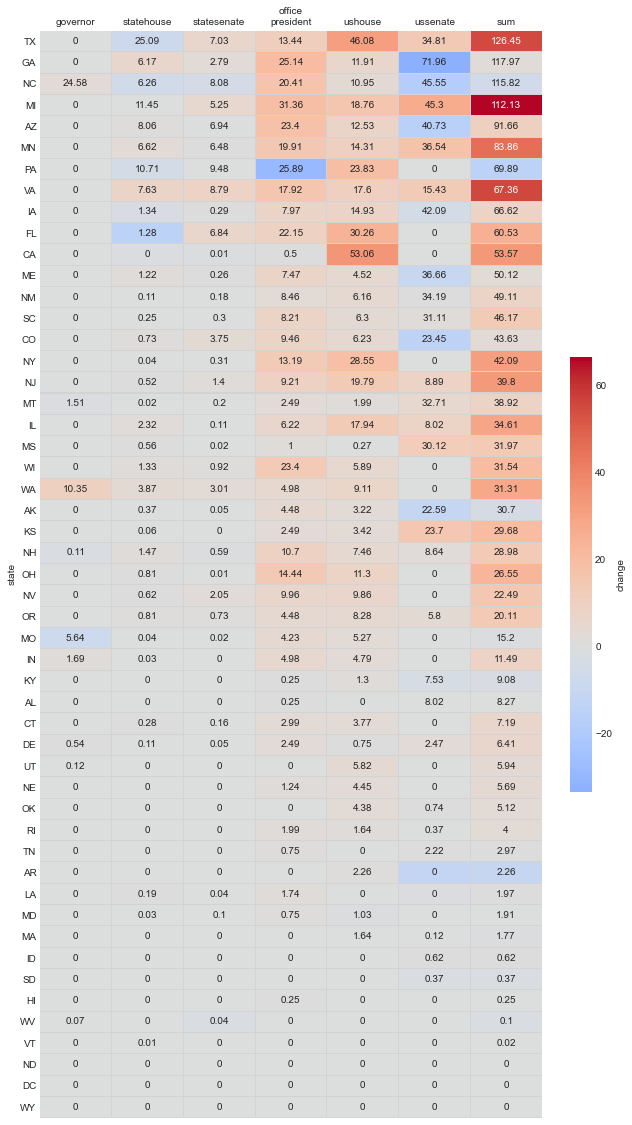

In [203]:
# Note, you can plot the absolute error here, then annotate it
# using a matrix of the same shape for coloring
# https://seaborn.pydata.org/generated/seaborn.heatmap.html

#http://seaborn.pydata.org/generated/seaborn.heatmap.html
fig, ax = plt.subplots(figsize=[10, 20]) #[7, 20] [20, 7] .T edgecolor='gray'
heatmap = sns.heatmap(np.around(error_matrix, decimals=2) , ax=ax,
    annot=np.around(matrix, decimals=2), fmt='g', linewidths=0.01, linecolor='lightgray',
    cbar=True, cbar_kws={'fraction':0.05,'shrink':0.4, 'label':'change'}, cmap='coolwarm', center=0.0) #cbar=False, coolwarm cmap="YlOrRd"  viridis 'cividis' YlGnBu Blues  best: OrRd PuBu
# heatmap = sns.heatmap(np.around(matrix, decimals=2) , ax=ax,
#     fmt='g', linewidths=0.01, linecolor='lightgray',
#     cbar=False, cmap='PuBu', annot=True)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
loc, labels = plt.yticks()
heatmap.set_yticklabels(labels, rotation=0)
plt.savefig(out_str.format('heatmap.png'), bbox_inches='tight')
heatmap

## Revealed preference via campaign spending

In [175]:
# Federal elections: https://www.followthemoney.org/tools/election-overview?s=US&y=2020
# State legislatures: https://www.followthemoney.org/show-me?dt=1&c-exi=1&c-r-ot=S,H#[{1|gro=c-r-ot,y
# Statewide governors: https://www.followthemoney.org/show-me?dt=1&f-fc=2&c-exi=1&c-r-ot=G,O#[{1|gro=c-r-ot,y
spending = pd.DataFrame(
    {'office': ['ushouse', 'ussenate', 'president', 'statehouse', 'statesenate', 'governor'],
    'funding': [1809039361, 2085584524, 3906050067, 877169550, 466552710, 163252382]})
spending = spending.eval('funding_pct = 100*funding/funding.sum()')
spending.sort_values(by='funding_pct', ascending=False)

,office,funding,funding_pct
2,president,3906050067,41.966024
1,ussenate,2085584524,22.407212
0,ushouse,1809039361,19.436051
3,statehouse,877169550,9.424180
4,statesenate,466552710,5.012573
5,governor,163252382,1.753959


In [244]:
power_frac = office_summary.copy()
power_frac.reset_index(drop=False, inplace=True)
del power_frac['change']
power_frac[['realized_power_2020', 'realized_power_model']] = \
    100*power_frac[['realized_power_2020', 'realized_power_model']] / \
    power_frac[['realized_power_2020', 'realized_power_model']].sum()
power_frac = power_frac.merge(spending[['office', 'funding_pct']], on='office')
power_frac.set_index('office', inplace=True)
power_frac = power_frac.sort_values(by='funding_pct', ascending=False)
power_frac = power_frac.style.format("{:.1f}").background_gradient()

m.output_table(power_frac, out_str.format('power_frac.html'))
power_frac

,realized_power_2020,realized_power_model,funding_pct
office,,,
president,11.4,22.4,42.0
ussenate,56.9,37.5,22.4
ushouse,13.5,26.7,19.4
statehouse,10.2,6.1,9.4
statesenate,4.1,4.6,5.0
governor,3.8,2.7,1.8


In [255]:
#!cp -vr data/output/evaluation/ ~/Documents/projects/pstblog/psthomas.github.io/images/elections-meta/evaluation/